# TAREA II - SEP I/A
<div style="text-align: justify;">

**PARTICIPANTES DEL PROYECTO:** NICOLÁS GONZÁLEZ - IVÁN TAPIA

In [1]:
import numpy as np

#DEFINICIÓN DE BASES Y PARÁMETROS DE LÍNEA - BARRA
R_km = 0.099
X_km = 0.156
Sb_VA = 100E6
Zb = ((220E3)**2)/Sb_VA
R_pu_km = R_km/Zb
X_pu_km = X_km/Zb 
P_pu = 150E6/Sb_VA
Q_pu = 150E6/Sb_VA

num_barras = 6
datos_barras = [
    {'type': 'PV', 'name': '2', 'P': 0, 'V': 1},                   # Barra 2 (PV)
    {'type': 'PQ', 'name': '1A', 'P': -1*P_pu*0.20, 'Q': -1*Q_pu*0.20},  # Barra 1A (PQ)
    {'type': 'PQ', 'name': '2A', 'P': -1*P_pu*0.35, 'Q': -1*Q_pu*0.35},  # Barra 2A (PQ)
    {'type': 'PQ', 'name': '3A', 'P': -1*P_pu*0.15, 'Q': -1*Q_pu*0.15},  # Barra 3A (PQ)
    {'type': 'PQ', 'name': '2B', 'P': -1*P_pu*0.60, 'Q': -1*Q_pu*0.60},  # Barra 2B (PQ)
    {'type': 'PQ', 'name': '1B', 'P': -1*P_pu*0.10, 'Q': -1*Q_pu*0.10},  # Barra 1B (PQ)
]
datos_lineas =[
    {'Bar_in':'2'  ,'Bar_out':'1A', 'R': R_pu_km*10, 'X': X_pu_km*10}, # Linea 2-1A
    {'Bar_in':'1A' ,'Bar_out':'2A', 'R': R_pu_km*15, 'X': X_pu_km*15}, # Linea 1A-2A
    {'Bar_in':'2A' ,'Bar_out':'3A', 'R': R_pu_km*20, 'X': X_pu_km*20}, # Linea 2A-3A
    {'Bar_in':'3A' ,'Bar_out':'2B', 'R': R_pu_km*15, 'X': X_pu_km*15}, # Linea 3A-2B
    {'Bar_in':'2B' ,'Bar_out':'1B', 'R': R_pu_km*30, 'X': X_pu_km*30}, # Linea 2B-1B
    {'Bar_in':'1B' ,'Bar_out':'2',  'R': R_pu_km*10, 'X': X_pu_km*10}  # Linea 1B-2
]

def calcular_matriz_admitancia(num_barras, datos_barras, datos_lineas):
    # Inicialización de la matriz Y_Bus
    Y_Bus = np.zeros((num_barras, num_barras), dtype=np.complex128)
    # Iterar sobre cada línea para obtener la matriz local y agregar a Y_Bus
    LB = [] #Lista de Nombres de Barras
    for p in range(num_barras): 
        LB.append(datos_barras[p]['name'])
    for linea in datos_lineas:
        Bar_in = linea['Bar_in']
        Bar_out = linea['Bar_out']
        R = linea['R']
        X = linea['X']
        # Calcular la matriz local
        Z_linea = R + 1j*X
        m = np.array([[1/Z_linea, -1/Z_linea], [-1/Z_linea, 1/Z_linea]])
        # Obtener índices de las barras en LB (Lista de Nombres de Barras)
        idx_in = next((i for i, v in enumerate(datos_barras) if v['name'] == Bar_in), None)
        idx_out = next((i for i, v in enumerate(datos_barras) if v['name'] == Bar_out), None)
        # Añadir contribución a Y_Bus
        if idx_in is not None and idx_out is not None:
            Y_Bus[idx_in, idx_in] += m[0, 0]  # Y_in,in += m11
            Y_Bus[idx_in, idx_out] += m[0, 1]  # Y_in,out += m12
            Y_Bus[idx_out, idx_in] += m[1, 0]  # Y_out,in += m21
            Y_Bus[idx_out, idx_out] += m[1, 1]  # Y_out,out += m22
    return Y_Bus

#Muestra Matriz Y_BUS        
BUS = calcular_matriz_admitancia(num_barras,datos_barras,datos_lineas)
filas, columnas = BUS.shape
for fila in BUS:
    for elemento in fila:
        print(f"{elemento.real: 9.4f}{elemento.imag:+9.4f}j", end="\t")
    print()

def evalua_f(Dim, datos_barras, theta, Y_Bus, V):
    f = np.zeros((Dim,1), dtype=np.complex128)
    for p in range(Dim):
        Pi_iny = 0
        Pi = 0
        for i in range(len(datos_barras)): #Sumatoria P
            Pi_iny = datos_barras[p]['P']
            for j in range(num_barras):
                if datos_barras[i] != datos_barras[j]:
                    Pi = Pi + V[i]*V[j]*(np.real(Y_Bus[i,j])*np.cos(theta[i]-theta[j]) + np.imag(Y_Bus[i,j])*np.sin(theta[i]-theta[j]))
        Delta_P = Pi_iny - Pi
        f[p,0] = Delta_P
        if datos_barras[p]['type'] == 'PQ':
            Qi_iny = 0
            Qi = 0
            for i in range(len(datos_barras)): #Sumatoria Q
                 Qi_iny = datos_barras[p]['Q']
                 for j in range(num_barras):
                    if datos_barras[i] != datos_barras[j]:
                        Qi = Qi + V[i]*V[j]*(np.real(Y_Bus[i,j])*np.sin(theta[i]-theta[j]) - np.imag(Y_Bus[i,j])*np.cos(theta[i]-theta[j]))
            Delta_Q = Qi_iny - Qi
            f[p,0] = Delta_Q
    return f

def calcular_flujo_potencia(Y_Bus, num_variables, datos_barras):
    # Inicialización del vector de incógnitas X
    X = np.ones(num_variables)  # Supongamos un valor inicial de 1 para todas las variables
    iteraciones = 0
    convergencia = False
    
    while not convergencia and iteraciones < max_iteraciones:
        iteraciones += 1
        # Construcción de F(X) y J(X)
        F = np.zeros(num_variables)
        J = np.zeros((num_variables, num_variables))
        
        for i in range(num_barras):
            tipo = datos_barras[i]['type']
            P = datos_barras[i].get('P', 0)  # Usar get para manejar el caso donde 'P' no está definido
            Q = datos_barras[i].get('Q', 0)  # Usar get para manejar el caso donde 'Q' no está definido
            
            if tipo == 'PV':
                # Ecuación de potencia activa para barra PV
                F[i] = X[i] - datos_barras[i]['V']
            elif tipo == 'PQ':
                # Ecuaciones de potencia activa y reactiva para barras PQ
                suma_P = 0
                suma_Q = 0
                for j in range(num_variables):
                    suma_P += X[j] * Y_Bus[i, j].real
                    suma_Q += X[j] * Y_Bus[i, j].imag
                F[num_barras + i] = P - suma_P
                F[num_barras + i + num_barras] = Q - suma_Q
                
                # Construcción de J(X)
                for j in range(num_variables):
                    J[num_barras + i, j] = -X[j] * Y_Bus[i, j].real
                    J[num_barras + i + num_barras, j] = -X[j] * Y_Bus[i, j].imag
        
        # Resolución del sistema lineal J(X) * dX = -F(X) para encontrar dX
        dX = solve(J, -F)
        
        # Actualización de X
        X += dX
        
        # Criterio de convergencia
        if np.max(np.abs(F)) < tolerancia:
            convergencia = True
    
    return X, iteraciones
# Calcular la matriz de admitancia Y_Bus
Y_Bus = calcular_matriz_admitancia(num_barras, datos_barras, datos_lineas)

# Resolver el flujo de potencia
solucion, num_iteraciones = calcular_flujo_potencia(Y_Bus, num_variables, datos_barras)

# Mostrar resultados
print("Resultados del flujo de potencia:")
for i in range(num_barras):
    print(f"Barra {datos_barras[i]['name']}: V = {solucion[i]:.4f} pu, θ = {solucion[num_barras + i - 1]:.4f} rad")

print(f"Número de iteraciones realizadas: {num_iteraciones}")

 280.7277-442.3587j	-140.3638+221.1794j	   0.0000  +0.0000j	   0.0000  +0.0000j	   0.0000  +0.0000j	-140.3638+221.1794j	
-140.3638+221.1794j	 233.9397-368.6323j	 -93.5759+147.4529j	   0.0000  +0.0000j	   0.0000  +0.0000j	   0.0000  +0.0000j	
   0.0000  +0.0000j	 -93.5759+147.4529j	 163.7578-258.0426j	 -70.1819+110.5897j	   0.0000  +0.0000j	   0.0000  +0.0000j	
   0.0000  +0.0000j	   0.0000  +0.0000j	 -70.1819+110.5897j	 163.7578-258.0426j	 -93.5759+147.4529j	   0.0000  +0.0000j	
   0.0000  +0.0000j	   0.0000  +0.0000j	   0.0000  +0.0000j	 -93.5759+147.4529j	 140.3638-221.1794j	 -46.7879 +73.7265j	
-140.3638+221.1794j	   0.0000  +0.0000j	   0.0000  +0.0000j	   0.0000  +0.0000j	 -46.7879 +73.7265j	 187.1518-294.9058j	


<div style="text-align: justify;">

# Análisis Con Panda Power
Se analiza el sistema de transmisión en estudio mediante la librería Panda Power. Con la finalidad de contrastar diferencias en ambos métodos de resolución de flujo de potencia.

In [2]:
import pandapower as pp

net2 = pp.create_empty_network()
#Carga Nominal Por Barra
P2 = 150 #MW
Q2 = 100 #MVAr
#Barras
b1 = pp.create_bus(net2, vn_kv=110, name='Barra 1', slack=True)
b2 = pp.create_bus(net2, vn_kv=220, name="Barra 2")
b1A = pp.create_bus(net2, vn_kv=220, name="Barra 1A")
b2A = pp.create_bus(net2, vn_kv=220, name="Barra 2A")
b3A = pp.create_bus(net2, vn_kv=220, name="Barra 3A")
b2B = pp.create_bus(net2, vn_kv=220, name="Barra 2B")
b1B = pp.create_bus(net2, vn_kv=220, name="Barra 1B")
#Elementos De Barra
pp.create_ext_grid(net2, bus=b1, vm_pu=1.00, name="Fuente Externa")
pp.create_load(net2, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
pp.create_load(net2, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
pp.create_load(net2, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
pp.create_load(net2, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
pp.create_load(net2, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")
#Elementos De Rama
tid = pp.create_transformer(net2, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")
#L 2 - 1A
pp.create_line(net2, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1A - 2A
pp.create_line(net2, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 2A - 3A
pp.create_line(net2, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 3A - 2B
pp.create_line(net2, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 2B - 1B
pp.create_line(net2, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1B - 2
pp.create_line(net2, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#Flujo De Carga
pp.runpp(net2)

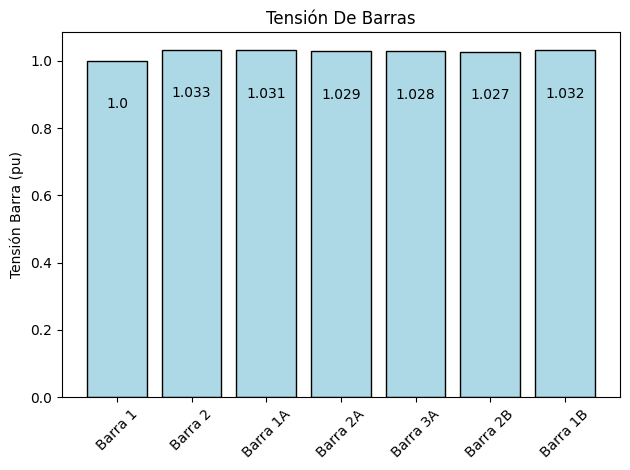

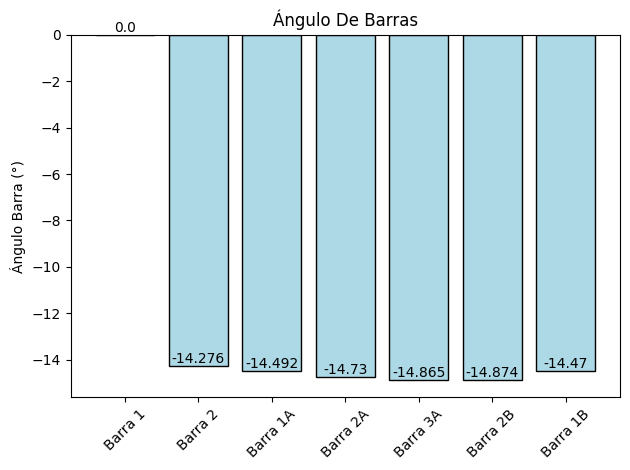

In [10]:
# Análisis de Tensiones de Barra
resultados_bus = net2.res_bus
import matplotlib.pyplot as plt
Bus = []
Voltage_pu = []
for n, lin in net2.bus.iterrows():
    Bus.append(lin['name'])
    res_bus1 = resultados_bus.loc[resultados_bus.index == n]
    Voltage_pu.append(round(res_bus1['vm_pu'].values[0],3))

plt.figure(3)
plt.bar(Bus, Voltage_pu, color='lightblue',edgecolor='black') 
plt.ylabel('Tensión Barra (pu)')
plt.xticks(rotation=45) 
plt.title('Tensión De Barras')
for i, valor in enumerate(Voltage_pu):
    plt.annotate(str(valor), xy=(i, valor-0.15), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Análisis de Ángulo en Barras
import matplotlib.pyplot as plt
Bus_2 = []
Ang_degree = []
for n, lin in net2.bus.iterrows():
    Bus_2.append(lin['name'])
    res_bus1 = resultados_bus.loc[resultados_bus.index == n]
    Ang_degree.append(round(res_bus1['va_degree'].values[0],3))

plt.figure(4)
plt.bar(Bus_2, Ang_degree, color='lightblue',edgecolor='black') 
plt.ylabel('Ángulo Barra (°)')
plt.xticks(rotation=45) 
plt.title('Ángulo De Barras')
for i, valor in enumerate(Ang_degree):
    plt.annotate(str(valor), xy=(i, valor), ha='center', va='bottom')
plt.tight_layout()
plt.show()